In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fraudsynth-credit-fraud-detection-dataset/fraud_detection_dataset.csv


In [2]:
import seaborn as ss
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression

In [3]:
fraud=pd.read_csv("/kaggle/input/fraudsynth-credit-fraud-detection-dataset/fraud_detection_dataset.csv")

In [4]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 10 columns):
 #   Column        Dtype  
---  ------        -----  
 0   timestamp     object 
 1   user_id       object 
 2   amount        float64
 3   location      object 
 4   device_type   object 
 5   is_fraud      int64  
 6   age           int64  
 7   income        float64
 8   debt          float64
 9   credit_score  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 152.6+ MB


In [5]:
#timestamp and userid are unique so removing the columns from the data
fraud_cp=fraud.copy()
fraud.drop(["timestamp","user_id"],axis=1,inplace=True)

In [6]:
fraud

,amount,location,device_type,is_fraud,age,income,debt,credit_score
0,998.99,Grantfurt,Mobile,0,56,42524.98,8394.05,655
1,241.39,Kimberlychester,Tablet,0,52,69884.04,28434.06,395
2,836.42,Gutierrezville,Desktop,0,58,126953.62,39121.78,496
3,612.74,Markside,Desktop,0,19,128650.70,39652.48,612
4,135.55,Anthonyshire,Tablet,0,59,102020.39,7439.81,302
...,...,...,...,...,...,...,...,...
1999995,3478.81,Joelview,Desktop,1,20,127482.32,6161.07,796
1999996,2337.90,Taylormouth,Mobile,1,22,94866.98,21614.64,660
1999997,2142.04,Coryview,Mobile,1,51,137229.33,5654.83,432
1999998,2452.60,Escobarfurt,Desktop,1,45,129794.90,34964.36,317


In [7]:
# Checking unique values in the location and device_type columns.
print(fraud["location"].nunique())
print(fraud["device_type"].nunique())

104592
3


<Axes: xlabel='is_fraud', ylabel='count'>

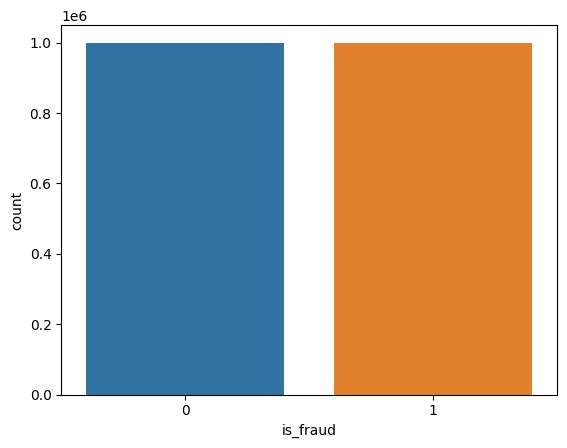

In [8]:
ss.countplot(fraud,x="is_fraud")

<Axes: xlabel='count', ylabel='device_type'>

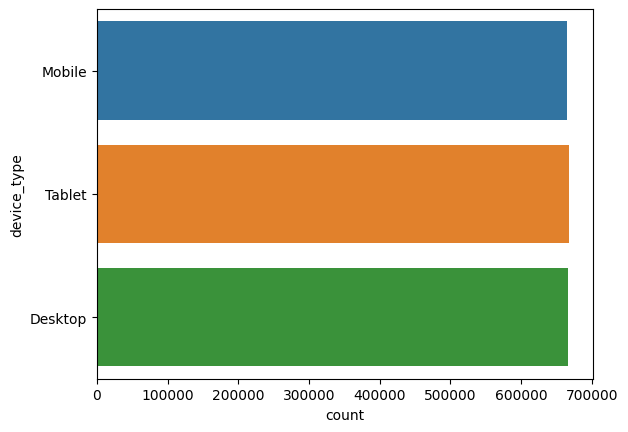

In [9]:
ss.countplot(fraud,y="device_type")

In [10]:
le=LabelEncoder()

In [11]:
#Encoding done for the object data type columns
list=fraud.select_dtypes(object).columns
for i in list:
    fraud[i]=le.fit_transform(fraud[i])

In [12]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   amount        float64
 1   location      int64  
 2   device_type   int64  
 3   is_fraud      int64  
 4   age           int64  
 5   income        float64
 6   debt          float64
 7   credit_score  int64  
dtypes: float64(3), int64(5)
memory usage: 122.1 MB


In [13]:
fraud["device_type"].nunique()

3

In [14]:
#standardisation done for columns which are mentioned in list
std=StandardScaler()
list=["amount","location","income","debt"]
for i in list:
    fraud[i]=std.fit_transform(fraud[[i]])

In [15]:
fraud

,amount,location,device_type,is_fraud,age,income,debt,credit_score
0,-0.500406,-0.865121,1,0,56,-1.132261,-1.148888,655
1,-1.004076,-0.719819,2,0,52,-0.403308,0.238920,395
2,-0.608486,-0.856240,0,0,58,1.117250,0.979064,496
3,-0.757194,-0.303331,0,0,19,1.162467,1.015816,612
4,-1.074441,-1.507884,2,0,59,0.452931,-1.214971,302
...,...,...,...,...,...,...,...,...
1999995,1.148236,-0.757951,0,1,20,1.131337,-1.303526,796
1999996,0.389732,1.355269,1,1,22,0.262336,-0.233338,660
1999997,0.259520,-1.350170,1,1,51,1.391036,-1.338584,432
1999998,0.465988,-0.928621,0,1,45,1.192953,0.691155,317


In [16]:
#checking correlation between dependent variables.
fraud.corr()

,amount,location,device_type,is_fraud,age,income,debt,credit_score
amount,1.000000,0.000402,-0.000787,0.829145,-0.000563,-0.000906,0.000776,0.000147
location,0.000402,1.000000,-0.000255,-0.000017,-0.001109,-0.000180,0.000277,-0.000622
device_type,-0.000787,-0.000255,1.000000,-0.000137,0.000661,-0.000192,0.000349,-0.001198
is_fraud,0.829145,-0.000017,-0.000137,1.000000,-0.000697,0.000016,0.000149,0.000427
age,-0.000563,-0.001109,0.000661,-0.000697,1.000000,-0.000185,-0.001130,-0.000113
income,-0.000906,-0.000180,-0.000192,0.000016,-0.000185,1.000000,-0.000387,0.000864
debt,0.000776,0.000277,0.000349,0.000149,-0.001130,-0.000387,1.000000,-0.000095
credit_score,0.000147,-0.000622,-0.001198,0.000427,-0.000113,0.000864,-0.000095,1.000000


In [17]:
# Assigning dependent variable to x and indepedent variable to y
x=fraud.drop("is_fraud",axis=1)
y=fraud["is_fraud"]

In [18]:
#train data and test data splitting
xtrain, xtest, ytrain, ytest=train_test_split(x,y,test_size=0.3,random_state=42)

# ****Model building using Logistic Regression

In [19]:
lg=LogisticRegression(max_iter=1000)
lg.fit(xtrain,ytrain)
yp=lg.predict(xtest)

In [20]:
accuracy_score(yp,ytest)

0.9980633333333333

In [21]:
print(classification_report(yp,ytest))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    301190
           1       1.00      1.00      1.00    298810

    accuracy                           1.00    600000
   macro avg       1.00      1.00      1.00    600000
weighted avg       1.00      1.00      1.00    600000



In [22]:
print(confusion_matrix(yp,ytest))

[[300028   1162]
 [     0 298810]]


# ****Model building using XGBoost classifier

In [23]:
#Building xgb classifier with randomized search CV 
model=XGBClassifier(random_state=42)
params=[{'n_estimators':[5,10,15,20],'max_depth':[3,4,5,6,7],'learning_rate':[0.0001,0.001,0.01,0.1]}]
modelxg=RandomizedSearchCV(model,params,n_iter=10,cv=5)
modelxg.fit(xtrain,ytrain)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   param_distributions=[{'learning_rate': [0.0001, 0.001, 0.01,
                                                           0.1],
                                         'max_depth': [3, 4, 5, 6, 7],
                                         'n_estimators': [5, 10, 15, 20]}])

In [24]:
#Fetching best parameters and their values
modelxg.best_params_

{'n_estimators': 15, 'max_depth': 3, 'learning_rate': 0.0001}

In [25]:
#Building final XGBoost model.
finalxg=XGBClassifier(n_estimators=20,max_depth=6,learning_rate=0.0001,random_state=42,n_iter=10)

In [26]:
finalxg.fit(xtrain,ytrain)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:07:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_iter" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20, n_iter=10, n_jobs=None,
              num_parallel_tree=None, ...)

In [27]:
ypred=finalxg.predict(xtest)

In [28]:
accuracy_score(ypred,ytest)

0.99971

In [29]:
print(classification_report(ypred,ytest))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    300190
           1       1.00      1.00      1.00    299810

    accuracy                           1.00    600000
   macro avg       1.00      1.00      1.00    600000
weighted avg       1.00      1.00      1.00    600000



In [30]:
print(confusion_matrix(ypred,ytest))

[[300022    168]
 [     6 299804]]


#  Build Logistic regression model and XGBoost model got accuracy score of 0.9980 for logistic regression model and 0.999 for xgboost. 
# **So XGBoost classifier model working well compare to Logistic regression.**